In [1]:
from datetime import datetime
import pandas as pd

# ====================================================
# https://pyproj4.github.io/pyproj/stable/
import pyproj

# ====================================================
# local imports
from src.bindings.positional.satelliteinformation_class import SatelliteInformation
from src.bindings.positional.coordinates_class import LLA_Coord
from src.bindings.positional.timeandlocation_class import TimeAndLocation
from src.bindings.models.ionospherestate_class import IonosphereState

from src.indexrefractionmodels.dispersionmodels_enum import DispersionModel
from src.indexrefractionmodels.transportmodes_enum import TransportMode
from src.positional.satellitepositiongenerator import SatellitePositionGenerator
from src.stratification.quantizationparameter_class import QuantizationParameter
from src.stratification.stratificationmethod_enum import StratificationMethod
from src.raypatheffects import EstimateRayPathEffects
# ====================================================
# constants
ECEF = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
LLA = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

In [2]:

s = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991'
t = '2 25544  51.6439 211.2001 0007417  17.6667  85.6398 15.50103472202482'
name = "Test"

satelliteInformation = SatelliteInformation(name=name, s=s, t=t)
satPosGenerator = SatellitePositionGenerator(satelliteInformation)

In [3]:
# Initial Starting Point

from src.positional.locationconverter_computations import LocationConverterComputation


currentDateTime = datetime(2016, 1, 26, 12, 0, 0)
sat_ECEF = satPosGenerator.estimatePosition_ECEF(currentDateTime)

# expected height, assume minimal change in position with range projection
event_LLA: LLA_Coord = LocationConverterComputation.convertFromECEFtoLLA(ecef=sat_ECEF)
event_LLA.setAltitude(0.0)


timeAndLocation = TimeAndLocation(
    eventLocation_LLA=event_LLA, eventTime_UTC=currentDateTime)

In [4]:
ionosphereState = IonosphereState(10.0, 10.0, [3.0, 3.0, 3.0])

# ======================================================
estimateRayPathEffects = EstimateRayPathEffects(
    timeAndLocation=timeAndLocation, dispersionModel=DispersionModel.X_MODEL, transportMode=TransportMode.PLASMA_MODE)

freq_Hz = 10e6

quantizationParameter = QuantizationParameter(StratificationMethod.DECIMATION_MODEL,nQuant=4)

transIonosphereEffects = estimateRayPathEffects.estimate(freq_Hz=freq_Hz, quantizationParameter=quantizationParameter, 
ionosphereState=ionosphereState, satelliteInformation=satelliteInformation)

In [5]:
print(transIonosphereEffects.totalIonoDelay_sec)
print(transIonosphereEffects.totalIonoLoss_db)

rayVectors = transIonosphereEffects.rayVectors
listTmp = []
columnNames = []
for rayVector in rayVectors:
    tmpList = rayVector.rayState.generateList()
    listTmp.append(tmpList)
    columnNames = rayVector.rayState.generateColumnNames()

df = pd.DataFrame(listTmp, columns = columnNames, dtype = float)

8264.134754579565
0.0


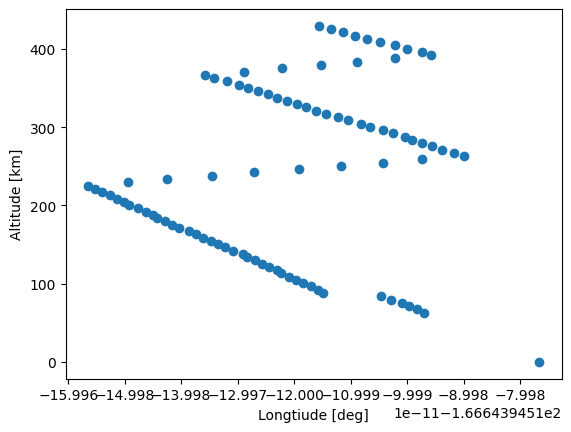

In [6]:
import matplotlib.pyplot as plt

fig = plt.scatter(df['Longitude'],  df['Altitude']/1000)

plt.xlabel("Longtiude [deg]")
plt.ylabel("Altitude [km]")

plt.show()